# Лабораторная работа № 5.

## Сети с обратными связями

Целью работы является исследование свойств сетей Хопфилда, Хэмминга и Элмана, алгоритмов обучения, а также применение сетей в задачах распознавания статических и динамических образов.

In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.utils as utils

Проверяю доступность видеокарты

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Всё обучение будет проходить на " + device)

Всё обучение будет проходить на cuda


### Задание 1

In [3]:
def p1(t):
    return np.sin(4 * np.pi * t)

def p2(t):
    return np.cos(-np.cos(t) * t ** 2 + t)

Сигнал и целевой выход

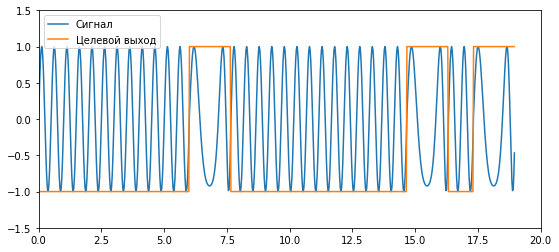

In [4]:
def make_signal(R):
    [r1, r2, r3] = R
    
    h = 0.025
    a2 = 2.9
    b2 = 4.55
    
    k1 = np.arange(0, 1, h)
    k2 = np.arange(a2, b2, h)
    
    p1_ = p1(k1)
    p2_ = p2(k2)
    
    t1_ = -1 * np.ones_like(k1)
    t2_ = np.ones_like(k2)
    
    x = np.concatenate((np.tile(p1_, r1), p2_, np.tile(p1_, r2), p2_, np.tile(p1_, r3), p2_))
    y = np.concatenate((np.tile(t1_, r1), t2_, np.tile(t1_, r2), t2_, np.tile(t1_, r3), t2_))
    
    n = x.shape[0]
    t = np.linspace(0, h * n, n)
    
    return (t, x, y)

R = [6, 7, 1]

(t, x, y) = make_signal(R)

figure = plt.figure(figsize = (9, 4))
ax = figure.add_subplot(111)
plt.plot(t, x, label = "Сигнал")
plt.plot(t, y, label = "Целевой выход")
plt.xlim(0, 20)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.show()

Подготовка обучающих данных

In [5]:
D = 4

n = x.shape[0]

train_x, train_y = [], []

for i in range(n - D):
    xx = x[i:i + D]
    yy = y[i:i + D]
    train_x.append(xx)
    train_y.append(yy)

train_x = np.array(train_x)
train_y = np.array(train_y)

train_xy = [(el_x, el_y) for el_x, el_y in zip(train_x, train_y)]

Dataloader

In [6]:
from torch.utils.data.dataloader import default_collate

def data_to_device(x):
    return tuple(x_.to(device) for x_ in default_collate(x))

dl_xy = torch.utils.data.DataLoader(train_xy, collate_fn = data_to_device, batch_size = 1, shuffle = False)

Построение модели

In [7]:
class ElmanLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in = size_in
        self.size_out = size_out
        
        self.w1 = nn.Parameter(torch.Tensor(size_in, size_out))
        self.w2 = nn.Parameter(torch.Tensor(size_out, size_out))
        self.b = nn.Parameter(torch.Tensor(size_out))
        nn.init.uniform_(self.w1)
        nn.init.uniform_(self.w2)
        nn.init.uniform_(self.b)
        
        self.empty_mem = torch.Tensor(torch.zeros(self.size_out)).to(device)
        self.clear_memory()

    def clear_memory(self):
        self.m = self.empty_mem.clone()
        
    def forward(self, x):
        y = torch.matmul(x, self.w1)
        y = torch.add(y, torch.matmul(self.m, self.w2))
        y = torch.add(y, self.b)
        y = torch.tanh(y)
        self.m = y.clone().detach().requires_grad_(False)
        return y


In [8]:
class ElmanNet(nn.Module):
    def __init__(self, size_in, size_hidden, size_out):
        super().__init__()
        self.size_in = size_in
        self.size_hidden = size_hidden
        self.size_out = size_out
        self.elman = ElmanLayer(size_in, size_hidden)
        self.linear = nn.Linear(size_hidden, size_out)

    def forward(self, x):
        x = self.elman(x)
        x = self.linear(x)
        return x

    def clear_memory(self):
        self.elman.clear_memory()        

Обучение сети

In [9]:
def fit_elman(net, train_xy, data, epoches = 10, lr = 1e-3, verbose = True):
        optim = torch.optim.Adam(net.parameters(), lr = lr)
        
        pred = []
        h = []
        for ep in range(epoches):
            net.clear_memory()
            mse_loss = []
            for x, y in train_xy:
                x = x.float()
                y = y.float()
                z = net(x)
                if (ep == epoches - 1):
                    pred.append(z.cpu().detach().numpy().item(0))
                loss = nn.MSELoss()(z, y)
                mse_loss.append(loss.item())
                optim.zero_grad()
                loss.backward()
                optim.step()
            mse_mean = np.mean(mse_loss)
            if (verbose):
                print(f"Epoch {ep + 1}:")
                print(f"MSE loss = {mse_mean}")
                print("=" * 32)
            h.append(mse_mean)

        figure = plt.figure(figsize = (16, 8))
        axes = figure.add_subplot(221)
        plt.plot(h)
        plt.ylabel("MSE")
        plt.xlabel("Эпохи")
        
        axes = figure.add_subplot(222)
        plt.plot(data[0], data[1], label = "Сигнал")
        plt.plot(data[0][:len(pred)], pred, label = "Предсказание")
        plt.xlim(0, 20)
        plt.ylim(-1.5, 1.5)
        plt.legend()
        
        axes = figure.add_subplot(223)
        plt.plot(data[0], data[1], label = "Сигнал")
        plt.plot(data[0], data[2], label = "Целевой выход")
        plt.xlim(0, 20)
        plt.ylim(-1.5, 1.5)
        plt.legend()
        
        pred = np.array(pred)
        pred[pred < 0] = -1
        pred[pred > 0] = 1
        
        axes = figure.add_subplot(224)
        plt.plot(data[0], data[1], label = "Сигнал")
        plt.plot(data[0][:len(pred)], pred, label = "Предсказание")
        plt.xlim(0, 20)
        plt.ylim(-1.5, 1.5)
        plt.legend()
        
        plt.show()
        del optim
        
        if (device == "cuda"):
            torch.cuda.empty_cache()

Если уменьшить размер скрытого слоя до $8$, то модели потребуется очень много эпох и маленькоий шаг обучения (```epoches = 200, lr = 1e-4```)

In [10]:
elnet = ElmanNet(size_in = D, size_hidden = 32, size_out = D).to(device)

Визуализация результата

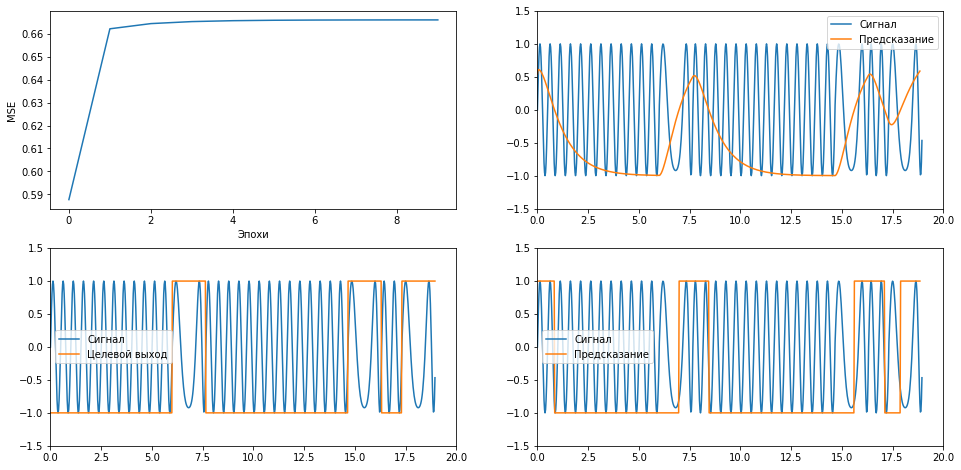

In [11]:
fit_elman(elnet, dl_xy, data = (t, x, y), epoches = 10, lr = 5e-4, verbose = False)

### Задание 2

In [12]:
mnist_data = datasets.MNIST(root = "data", train = False,
                            download = True, transform = ToTensor())

In [13]:
mnist_digits = [[] for _ in range(10)]

for elem in mnist_data:
    (x, y) = elem
    mnist_digits[y].append(2 * x - 1)

In [14]:
task2 = [1, 6, 9]

In [15]:
def display_images(data, max_n = 8):
    n = min(max_n, len(data))
    fig, ax = plt.subplots(1, n, figsize = (2 * n, 2))
    for i in range(n):
        img = data[i].detach().cpu().numpy()
        ax[i].imshow(img.transpose(1, 2, 0))
        ax[i].axis("off")
    plt.tight_layout()
    plt.show()

Пример данных

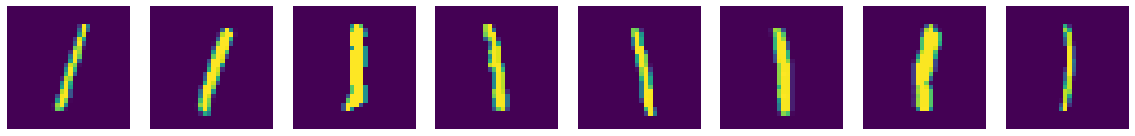

In [16]:
display_images(mnist_digits[task2[0]])

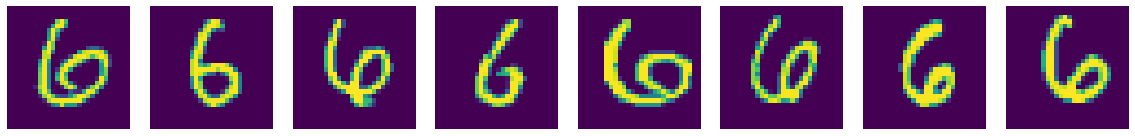

In [17]:
display_images(mnist_digits[task2[1]])

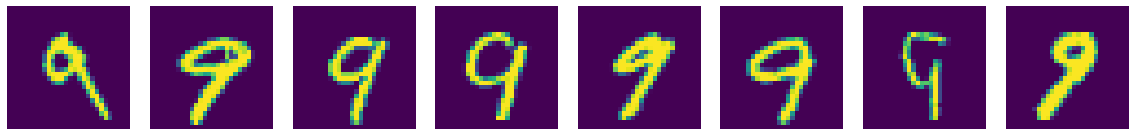

In [18]:
display_images(mnist_digits[task2[2]])

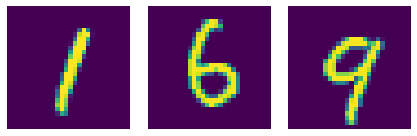

In [19]:
task2id = [1, 1, 2]

train_digits = [mnist_digits[task2[0]][task2id[0]], mnist_digits[task2[1]][task2id[1]], mnist_digits[task2[2]][task2id[2]]]

display_images(train_digits)

Построение модели

In [20]:
class HopfieldNet(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.size = size
        
        self.w = nn.Parameter(torch.Tensor(size, size))
        self.b = nn.Parameter(torch.Tensor(size))
        nn.init.zeros_(self.w)
        nn.init.zeros_(self.b)
        
        self.m = torch.Tensor(torch.zeros(self.size)).to(device)
        
    def set_input(self, x):
        # self.m = torch.Tensor(x)
        self.m = x.clone().detach().requires_grad_(False)

    def forward(self, x = 0):
        y = torch.matmul(self.m, self.w)
        y = torch.add(y, self.b)
        y = torch.clamp(y, min = -1, max = 1)
        # self.m = torch.Tensor(y)
        self.m = torch.Tensor(y).detach().requires_grad_(False)
        return y

Функция для обучения модели

In [21]:
def fit_hopfield(net, imgs, epoches = 10, lr = 1e-3, verbose = True, eps = 1e-3):
    hopnet.train()
    optim = torch.optim.SGD(net.parameters(), lr = lr)
    
    n = len(imgs)
    for i in range(n):
        imgs[i] = imgs[i].flatten().to(device)

    h = []
    for ep in range(epoches):
        img_losses = []
        for img in imgs:        
            net.set_input(img)
            z = net(img)
            loss = nn.MSELoss()(z, img)
            img_losses.append(loss.item())
            optim.zero_grad()
            loss.backward()
            optim.step()

        h.append(np.mean(img_losses))
        if (verbose):
            print(f"Epoch {ep + 1}:")
            print(f"MSE loss = {h[-1]}")
            print("=" * 32)

    figure = plt.figure(figsize = (16, 9))
    axes = figure.add_subplot(111)
    plt.plot(h)
    plt.ylabel("MSE")
    plt.xlabel("Эпохи")
    plt.show()
    del optim

    if (device == "cuda"):
        torch.cuda.empty_cache()

Функция для распознавания моделей

In [22]:
def eval_hopfield(net, img, iterations = 8, noise = False, noise_max = 1):
    net.eval()    
    x = img.flatten()
    if (noise):
        delta = torch.tensor(np.random.uniform(-noise_max, noise_max, 28 * 28))
        x = (x + delta) / 2
    x = x.float().to(device)
    res = []
    net.set_input(x)
    for ep in range(iterations):
        res.append(net.m.clone().detach().reshape((1, 28, 28)))
        net(x)
    display_images(res, iterations)
    if (device == "cuda"):
        torch.cuda.empty_cache()

Обучение на трёх образцах

In [23]:
hopnet = HopfieldNet(28 * 28).to(device)

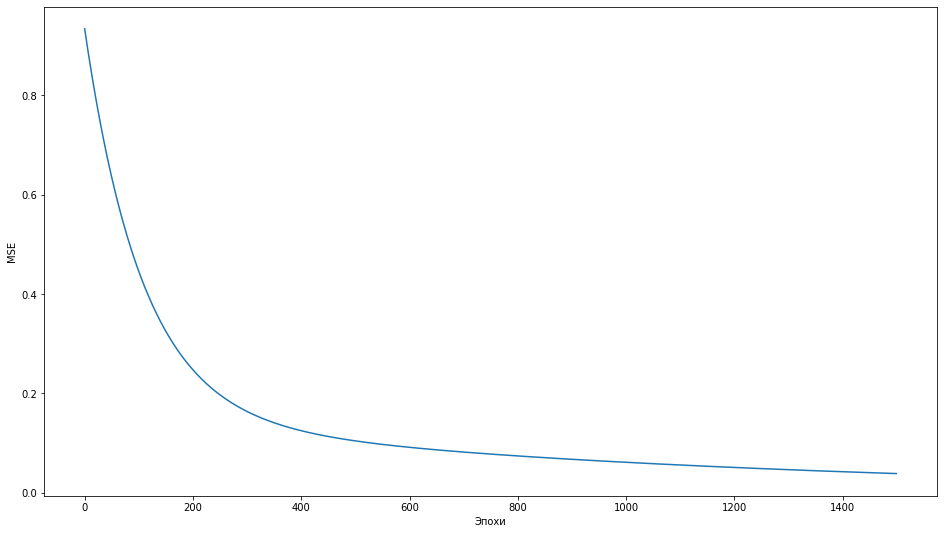

In [24]:
fit_hopfield(hopnet, train_digits, epoches = 1500, lr = 1e-3, verbose = False)

Распознавание цифр с шумом и без

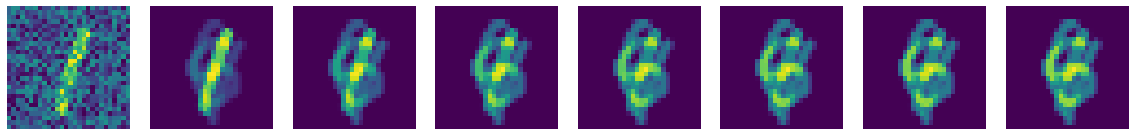

In [25]:
eval_hopfield(hopnet, mnist_digits[task2[0]][task2id[0]], iterations = 8, noise = True, noise_max = 1)

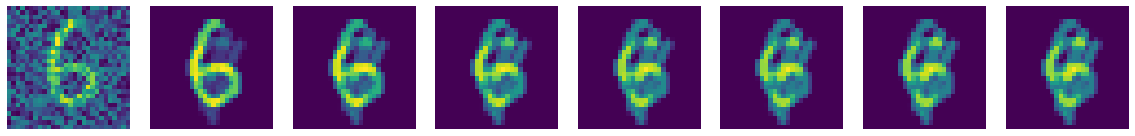

In [26]:
eval_hopfield(hopnet, mnist_digits[task2[1]][task2id[1]], iterations = 8, noise = True, noise_max = 1)

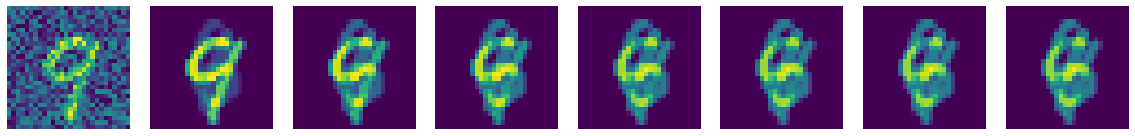

In [27]:
eval_hopfield(hopnet, mnist_digits[task2[2]][task2id[2]], iterations = 8, noise = True, noise_max = 1)

### Вывод

В ходе выполнения лабораторной работы я ознакомился с сетями Элмана и Хопфилда.

Реализовал сеть Элмана для распознавания динамического образа и сеть Хопфилда для распознавания статического образа.